In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from importlib import reload

import train as t
import model
import loss
import utils

In [ ]:
reload(utils)

In [ ]:
reload(model)

In [ ]:
reload(t)

In [ ]:
rm -rf logs/

In [ ]:
s2s = t.Seq2Seq(fasta_path='Nucleosom_data/Reference sequence-chrI-1..230218.fasta',
                histone_path='Nucleosom_data/Chereji_2018_Occupancy_H3_CC_V64-chrI-1..230218.bedgraph',
                input_size=5,
                output_size=1,
                batch_size=32,
                seq_len_DNA=100,
                seq_len_hist=100,
                Nepochs=1,
                hidden_size=32,
                dropout_p=0.2,
                n_layers=5)

In [ ]:
s2s.train()

In [ ]:
decoder_outputs, attention_list = s2s.predict(fasta_path='Nucleosom_data/Reference sequence-chrI-1..230218.fasta')

In [ ]:
import torch
xs=[]
ys=[]
for x,y in s2s.train_loader:
    xs.append(x)
    ys.append(y)
xs = torch.cat(xs,0).cpu().numpy()
ys = torch.cat(ys,0).cpu().numpy()

In [20]:
print(decoder_outputs.shape,ys.shape)

(1824, 1, 100) (1824, 1, 100)


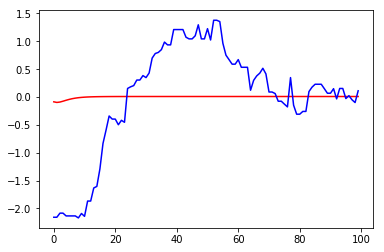

In [21]:
plt.plot(decoder_outputs[10,0,:],'r')
plt.plot(ys[10,0,:],'b')
plt.show()